In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from src.domain import Domain
from src.interpolation import SplineInter
from src.transformations import Affine2d
from src.plotting import view_image_2d, plot_grid_2d
from src.super_resolution_tools import *
from src.transformations import Affine2d
from src.LinearOperator import LinearOperator
import torch.optim as optim
from src.lanczos import lanczos_tridiag
from src.conjugate_gradient import conjugate_gradient
import time
from src.utils import vec_to_params, params_to_vec, extract_jac_data_SR, vec_to_paramdic, extract_jac_data
import torch.func as func
from src.distance import SSDDistance
import time

In [2]:
def randomAffines(reference, n):
    affines = [getRandomAffine() for a in range(n-1)]
    templates = [down_sample(reference(xc).reshape(m, m), factor)]
    for aff in affines:
        affine = Affine2d()
        affine.A = torch.nn.Parameter(aff[0])
        affine.b = torch.nn.Parameter(aff[1])
        templates.append(down_sample(reference(affine(xc)).reshape(m, m), factor))
    return torch.stack(templates)


In [3]:
m = 128
factor = 4
theta = 0.1
numberofimages = 3

domain_R = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m, m)))
domain_T = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m//factor, m//factor)))
xc = domain_R.getCellCenteredGrid().view(-1, 2)

times = torch.linspace(0, 15, numberofimages)

R = Image.open('../data/hands-R.jpg')
R = R.resize((m, m))
R = torch.fliplr(torch.tensor(R.getdata(), dtype=torch.float32).view(m,m).transpose(0,1))
Rimg = SplineInter(R, domain_R ,regularizer='moments',theta=theta)

T = randomAffines(Rimg, len(times))

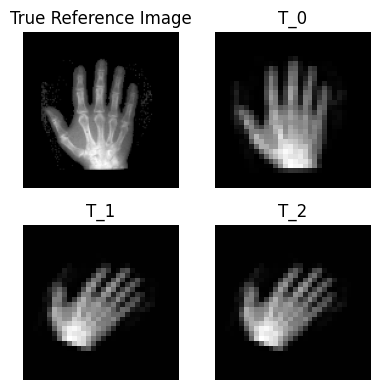

In [4]:
# Determine the layout for the subplots
num_images = 1 + len(T)  # Total number of images (reference + targets)
cols = int(torch.ceil(torch.sqrt(torch.tensor(num_images).float())))  # Number of columns (and rows in a square layout)
rows = int(torch.ceil(torch.tensor(num_images).float() / cols))  # Number of rows needed to accommodate all images

# Create the figure with subplots
fig, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

# Flatten the ax array for easier indexing
ax = ax.flatten()

# Display the reference image
ax[0].imshow(R.T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
ax[0].set_title('True Reference Image')
ax[0].axis('off')  # Optional: hide axes for cleaner visualization

# Display the target images
for k in range(len(T)):
    ax[k + 1].imshow(T[k].detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
    ax[k + 1].set_title(f'T_{k}')
    ax[k + 1].axis('off')  # Optional: hide axes for cleaner visualization

# Turn off any unused subplots
for i in range(1 + len(T), len(ax)):
    ax[i].axis('off')

plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
plt.show()

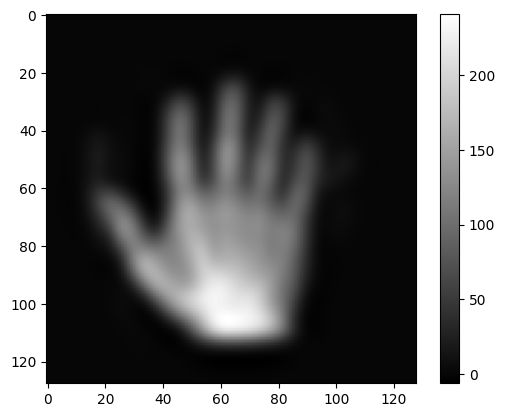

In [5]:
T_avg = T[0] # + T.mean(axis=0)
T_avg_img = SplineInter(T_avg, domain_T, regularizer='moments',theta=theta)
R0 = T_avg_img(domain_R.getCellCenteredGrid()).reshape(*domain_R.m)
plt.imshow(R0.detach().T.flip(0), cmap='gray')
plt.colorbar()

In [6]:
def show_estimated(A, pred, i):

    # Determine the layout for the subplots
    num_images = 1 + len(T)  # Total number of images (reference + targets)
    cols = int(torch.ceil(torch.sqrt(torch.tensor(num_images).float())))  # Number of columns (and rows in a square layout)
    rows = int(torch.ceil(torch.tensor(num_images).float() / cols))  # Number of rows needed to accommodate all images

    # Create the figure with subplots
    fig, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

    # Flatten the ax array for easier indexing
    ax = ax.flatten()

    # Display the reference image
    ax[0].imshow(A.detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
    ax[0].set_title('Estimated Reference Image')
    ax[0].axis('off')  # Optional: hide axes for cleaner visualization

    # Display the target images
    for k in range(len(T)):
        ax[k + 1].imshow(pred[k].detach().T.flip(dims=(0,)))  # Convert tensor to NumPy array for imshow
        ax[k + 1].set_title('Estimated ' + f'T_{k}')
        ax[k + 1].axis('off')  # Optional: hide axes for cleaner visualization

    # Turn off any unused subplots
    for i in range(1 + len(T), len(ax)):
        ax[i].axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
    plt.show()


In [7]:
# # JACOBIAN CHECK
# # credit to Cash for code
def jacobian_check(f, x, Jac, max_iters=32):
    
    v = torch.rand(x.numel())
    h = torch.zeros(max_iters)
    err0 = torch.zeros(max_iters)
    err1 = torch.zeros(max_iters)

    for i in range(max_iters):
        h[i] = 2**(-i) # halve our stepsize every time

        fv = torch.flatten(f((x.flatten() + h[i]*v).reshape(x.shape)))
        T0 = torch.flatten(f(x))

        T1 = torch.flatten(T0) + h[i]*(Jac @ v)

        err0[i] = torch.norm(fv - T0) # this error should be linear
        err1[i] = torch.norm(fv - T1) # this error should be quadratic

        # print('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])

        print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

        import matplotlib.pyplot as plt

    plt.loglog(h.detach(), err0.detach(), linewidth=3)
    plt.loglog(h.detach(), err1.detach(), linewidth=3)
    plt.legend(['$\|f(x) - T_0(x)\|$', '$\|f(x)-T_1(x)\|$'], fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

In [12]:

max_iter = 500
tol = 1e-4
dist = SSDDistance(domain_T)
xc = domain_R.getCellCenteredGrid().view(-1,2)

R_hat = R0.clone()
R_shape = R_hat.shape

D = LinearOperator( # derivate matrix
    R_shape,   
    lambda A : torch.vstack([torch.diff(A,dim=i).flatten()/domain_R.h[i] for i in [0,1]])
    )

H_R = torch.prod(domain_R.h)
H_T = torch.prod(domain_T.h)

# grid size factor for integrating
L2_R = lambda A : torch.linalg.norm(A)**2 * H_R
L2_T = lambda B : torch.linalg.norm(B)**2 * H_T

trafo = [Affine2d() for _ in range(len(times)-1)] # the transformation for the 0th image will always the be identity
wc = torch.stack([params_to_vec(t) for t in trafo]) # wc is expected to be 1D so store shapes to reshape back in FR
u, l = wc.shape[0], wc.shape[1]
wc = wc.flatten()
wp = [{k: v for k, v in t.named_parameters()} for t in trafo]
shapes = [{k: v.shape for k, v in w.items()} for w in wp]

a = 5e-3


def res(wc, xc, shapes, grad=True, max_iters=None):

    #wc is 1d and needs to be reshaped back to stacked version
    wc = wc.view(u, l)
    
    if not grad:
        wp_grad = [vec_to_paramdic(wc[i], shapes[i]) for i in range(len(trafo))]
        aff_grad = [Affine2d()(xc)] + [func.functional_call(trafo[i], wp_grad[i], xc) for i in range(len(trafo))]
        wc = wc.detach()

    # will use detached version of wc not grad and will use wc that requires grad if grad true
    wp = [vec_to_paramdic(wc[i], shapes[i]) for i in range(len(trafo))]
    aff = [Affine2d()(xc)] + [func.functional_call(trafo[i], wp[i], xc) for i in range(len(trafo))]

    def forward(A):
        A_img = SplineInter(A,domain_R, theta) # this is our current guess of R

        # we now guess the Ts, such that R(y(x)) = T (opposite from image registration)
        T_pred_highres = torch.stack([A_img(aff[t]).reshape(R_shape) for t in range(times.shape[0])], dim=0)
        # downsample the predicted Ts
        T_pred = torch.stack(
            [down_sample(T_pred_highres[i], factor) for i in range(T_pred_highres.shape[0])],
            dim = 0
        )

        return T_pred

    F = LinearOperator(R_shape, forward)

    ATA = lambda R : (((F.T ^ F & H_R) + ((D.T ^ D & (H_T)) & a)).forward(R.reshape(R_shape))).flatten()
    ATb = H_R * (F.T @ T).flatten()

    R_hat_new = conjugate_gradient(ATA, ATb, R_hat, tol=1e-5, max_iters=max_iters).reshape(R_shape)
    
    # switch back to differentiating here
    if not grad:
        wp = wp_grad
        aff = aff_grad

    output = F @ R_hat_new #F @ R_hat_new
    D.adjoint_func = None
    D.output_shape = None

    return torch.sqrt(torch.prod(domain_T.h)) * (output - T).flatten()  #regularization should be included here


def jac(wc, xc, shapes, grad=True, max_iters=None):
    jac = func.jacfwd(res)(wc, xc, shapes)
    return jac

print("p", wc.shape)
residual = res(wc, xc, shapes)
print("res", residual.shape)
print("wc", wc.shape)
jac = jac(wc, xc, shapes)
print("jac",jac.shape)

from src.optimization import lsq_lma

results, hess, loss_lma, grad_lma = lsq_lma(p=wc,
                                        function=res, 
                                        jac_function=jac,
                                        args=(xc, shapes, True, None),
                                        gtol=1e-5,
                                        ptol=1e-50,
                                        max_iter=1000,
                                        return_loss_and_grad=True)


p torch.Size([12])
res torch.Size([3072])
wc torch.Size([12])
wc jac torch.Size([12])
